<a href="https://colab.research.google.com/github/naoya1110/jetbot_road_following_by_classification/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Following by Classification - Train Model

## Introduction
In this notebook, we train a CNN model with the image data we collected using the JetBot.

### General Python Packages

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm.notebook import tqdm

### GPU

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


## Data Preparation

### Upload and extract dataset

We need to upload the ``dataset.zip`` file in the file browser on the left and then extract it.

In [ ]:
! unzip -q dataset.zip

Now we should see a folder named ``dataset`` appear in the file browser.

#### *If your `dataset.zip` file is in your google drive*

You can mount your google drive with,

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then extract the `dataset.zip` file.

In [ ]:
!unzip -q /path/to/your/dataset.zip

### Remove Broken Data
The dataset directory may contain some broken image for some reasons. Such data will cause errors when we train the model. So it is better to remove such data before hand.

In [ ]:
subdirs = sorted(os.listdir("dataset"))

for subdir in subdirs:
    filenames = os.listdir(os.path.join("dataset", subdir))
    for filename in filenames:
        path = os.path.join("dataset", subdir, filename)
        img = cv2.imread(path)
        if img is None:
            os.remove(path)
            print("Removed", path)

### Check Number of Images
Let's chack number of images that we have now.

In [ ]:
n_files = []

for subdir in subdirs:
    n_file =  len(os.listdir(os.path.join("dataset", subdir)))
    print(subdir, n_file)
    n_files.append(n_file)

    if n_files == 0:
        os.rmdir(os.path.join("dataset", subdir))
        print(f"removed sub directory:{subdir}")

n_files = np.array(n_files)

forward 578
left 296
right 860
[578 296 860]


### Class Weights

In [ ]:
n_total = n_files.sum()
class_weights = (1/n_files)*(n_total/3)
class_weights

array([1.        , 1.9527027 , 0.67209302])

## Build CNN Model

### Import PyTorch Packages

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

### Create Dataset

Now we use the ``ImageFolder`` dataset class available with the ``torchvision.datasets`` package.  We attach transforms from the ``torchvision.transforms`` package to prepare the data for training.  

In [ ]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

dataset = datasets.ImageFolder(
    'dataset',
    transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
)

### Class Index

In [ ]:
dataset.class_to_idx

{'forward': 0, 'left': 1, 'right': 2}


Next, we split the dataset into *training* and *test* sets.  The test set will be used to verify the accuracy of the model we train.

### Split dataset into train and test sets

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100])

### Data Loaders

We'll create two ``DataLoader`` instances, which provide utilities for shuffling data, producing *batches* of images, and loading the samples in parallel with multiple workers.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=20,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=20,
    shuffle=True,
    num_workers=2
)

### Model Architecture

In [ ]:
import torch.nn as nn

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),    # dropout layer
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        return x
    
model = Model().to(device)
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias

### torchinfo

In [ ]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([20, 3, 224, 224])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Sequential: 1-1                        [20, 64, 7, 7]            --
│    └─Conv2d: 2-1                       [20, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [20, 64, 224, 224]        --
│    └─MaxPool2d: 2-3                    [20, 64, 112, 112]        --
│    └─Conv2d: 2-4                       [20, 64, 112, 112]        36,928
│    └─ReLU: 2-5                         [20, 64, 112, 112]        --
│    └─MaxPool2d: 2-6                    [20, 64, 56, 56]          --
│    └─Conv2d: 2-7                       [20, 64, 56, 56]          36,928
│    └─ReLU: 2-8                         [20, 64, 56, 56]          --
│    └─MaxPool2d: 2-9                    [20, 64, 28, 28]          --
│    └─Conv2d: 2-10                      [20, 64, 28, 28]          36,928
│    └─ReLU: 2-11                        [20, 64, 28, 28]          --


### Train the neural network

Using the code below we will train the neural network for 30 epochs, saving the best performing model after each epoch.

> An epoch is a full run through our data.

In [ ]:
model = Model()

device = torch.device('cuda')
model = model.to(device)

#class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_func = nn.CrossEntropyLoss(weight=class_weights)                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-4)    # set optimizer
epochs = 20

best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test accuracy improved from {best_accuracy:.3f} to {test_accuracy:.3f}")
        print(f"Model saved at {best_model_path}")
        best_accuracy = test_accuracy

-----------------------------
Epoch 1/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.340 Loss=1.088, Test: Accuracy=0.620 Loss=1.028
Test accuracy improved from 0.000 to 0.620
Model saved at best_model.pth
-----------------------------
Epoch 2/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.657 Loss=0.817, Test: Accuracy=0.710 Loss=0.657
Test accuracy improved from 0.620 to 0.710
Model saved at best_model.pth
-----------------------------
Epoch 3/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.715 Loss=0.694, Test: Accuracy=0.740 Loss=0.537
Test accuracy improved from 0.710 to 0.740
Model saved at best_model.pth
-----------------------------
Epoch 4/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.732 Loss=0.633, Test: Accuracy=0.790 Loss=0.497
Test accuracy improved from 0.740 to 0.790
Model saved at best_model.pth
-----------------------------
Epoch 5/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.754 Loss=0.584, Test: Accuracy=0.800 Loss=0.467
Test accuracy improved from 0.790 to 0.800
Model saved at best_model.pth
-----------------------------
Epoch 6/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.745 Loss=0.599, Test: Accuracy=0.780 Loss=0.473
-----------------------------
Epoch 7/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.763 Loss=0.557, Test: Accuracy=0.790 Loss=0.480
-----------------------------
Epoch 8/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.761 Loss=0.541, Test: Accuracy=0.810 Loss=0.443
Test accuracy improved from 0.800 to 0.810
Model saved at best_model.pth
-----------------------------
Epoch 9/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.784 Loss=0.529, Test: Accuracy=0.820 Loss=0.453
Test accuracy improved from 0.810 to 0.820
Model saved at best_model.pth
-----------------------------
Epoch 10/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.776 Loss=0.514, Test: Accuracy=0.790 Loss=0.411
-----------------------------
Epoch 11/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.781 Loss=0.508, Test: Accuracy=0.790 Loss=0.458
-----------------------------
Epoch 12/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.774 Loss=0.497, Test: Accuracy=0.790 Loss=0.455
-----------------------------
Epoch 13/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.789 Loss=0.476, Test: Accuracy=0.810 Loss=0.435
-----------------------------
Epoch 14/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.798 Loss=0.470, Test: Accuracy=0.790 Loss=0.437
-----------------------------
Epoch 15/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.794 Loss=0.465, Test: Accuracy=0.790 Loss=0.451
-----------------------------
Epoch 16/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.805 Loss=0.443, Test: Accuracy=0.800 Loss=0.422
-----------------------------
Epoch 17/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.813 Loss=0.444, Test: Accuracy=0.800 Loss=0.444
-----------------------------
Epoch 18/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.804 Loss=0.455, Test: Accuracy=0.790 Loss=0.448
-----------------------------
Epoch 19/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.814 Loss=0.418, Test: Accuracy=0.780 Loss=0.447
-----------------------------
Epoch 20/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.810 Loss=0.416, Test: Accuracy=0.790 Loss=0.461


### Learning Curves

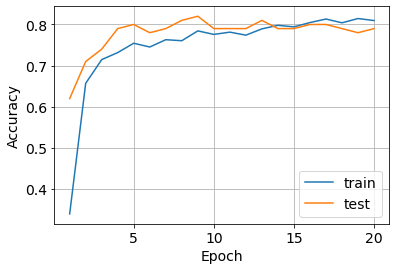

In [ ]:
plt.rcParams["font.size"]=14
real_epochs = len(train_accuracy_list)

plt.plot(np.arange(real_epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(real_epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

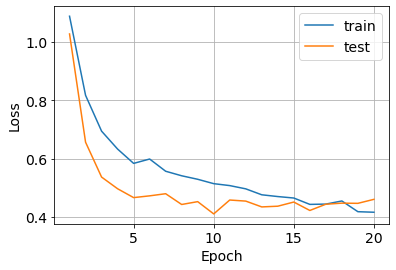

In [ ]:
plt.plot(np.arange(real_epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(real_epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Evaluation

In [ ]:
model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initialized model

<All keys matched successfully>

In [ ]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode
    
    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.820


[[19  3  7]
 [ 2 16  1]
 [ 4  1 47]]


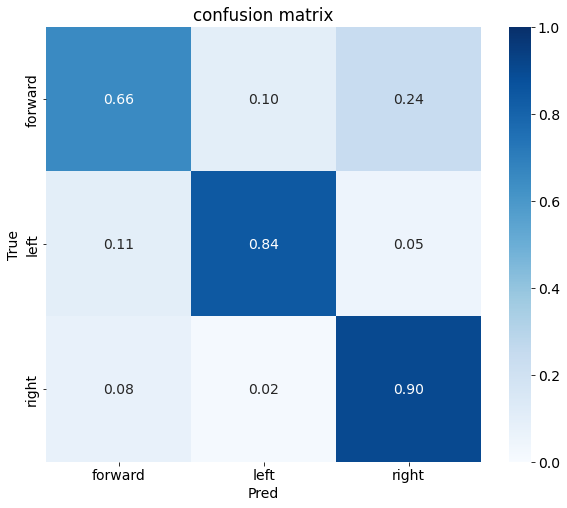

In [ ]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,8))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

#sns.heatmap(cmx, annot=True, fmt=".0f", cmap="Blues", vmin=0, vmax=1,
#            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

print(cmx)

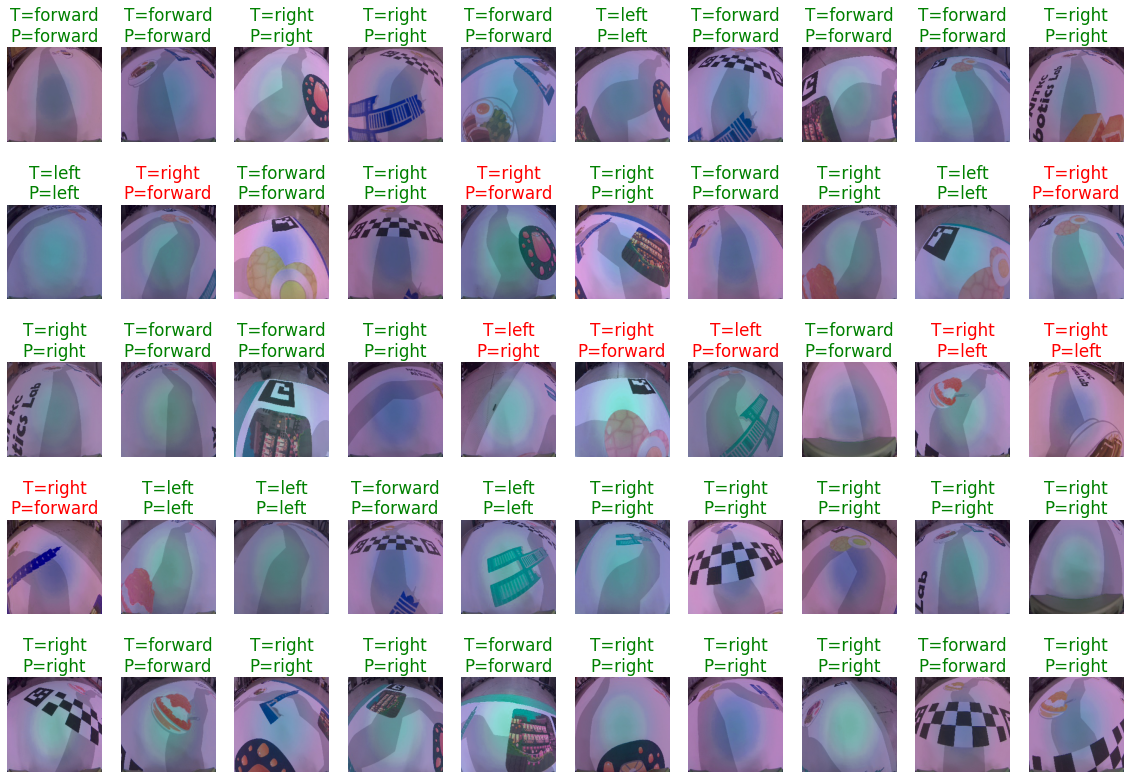

In [ ]:
plt.figure(figsize=(20, 14))

for i in range(50):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))

    image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]

    plt.subplot(5, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")

Once that is finished, you should see a file ``best_model.pth`` in the Jupyter Lab file browser.  Select ``Right click`` -> ``Download`` to download the model to your workstation